Device: cuda, Workers: 0
Classes: ['Steps', 'Vehicle', 'Noise']
Output Path: .\saved_models\stats_only_mlp_run_20250401_120851
MLP Params: LR=1.0e-03, Dropout=0.3
Training: Batch=64, Epochs=100, Patience=15
--- Loading Original Signals (Keeping Files Intact) ---
Loading: man.csv (Label: Steps)
  Loaded 34001 valid rows with 37 columns.
Loading: car.csv (Label: Vehicle)
  Loaded 16998 valid rows with 12 columns.
Loading: car2.csv (Label: Vehicle)
  Loaded 30000 valid rows with 12 columns.
Loading: nothing.csv (Label: Noise)
  Loaded 25961 valid rows with 39 columns.
----------------------------------------
Total original files loaded successfully: 4


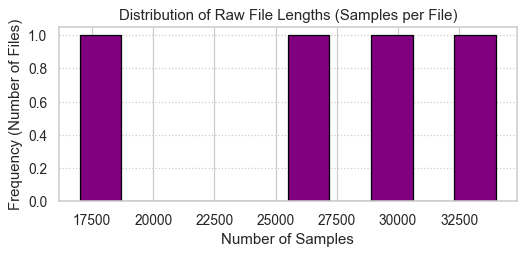


--- Splitting 4 Original Files (20% Validation) ---
Using stratification seed: 42
Split complete:
  Training files: 3
  Validation files: 1


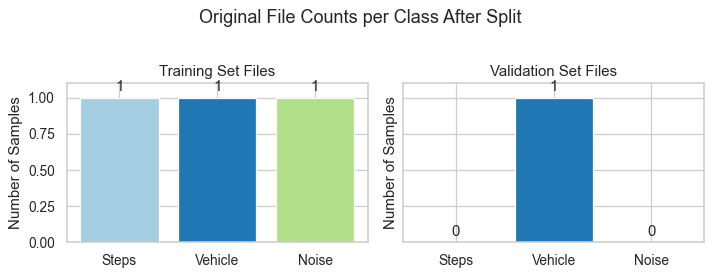


--- Expanding Channels & Processing for Training Set (Stats Only) ---
 Proc file 3/3 (car2.csv)......
Finished expanding & processing Training:
  Total channels processed: 88
  Total windows generated: 9873
  Total windows skipped: 0
  Skipped reasons: {'filter_short': 0, 'stat_nan_inf': 0, 'stat_shape': 0, 'other_exception': 0, 'channel_empty': 0}

--- Expanding Channels & Processing for Validation Set (Stats Only) ---
 Proc file 1/1 (car.csv)...
Finished expanding & processing Validation:
  Total channels processed: 12
  Total windows generated: 720
  Total windows skipped: 0
  Skipped reasons: {'filter_short': 0, 'stat_nan_inf': 0, 'stat_shape': 0, 'other_exception': 0, 'channel_empty': 0}
----------------------------------------
Processed Training:
 Stats: (9873, 21)
 Labels: (9873,)

Processed Validation:
 Stats: (720, 21)
 Labels: (720,)


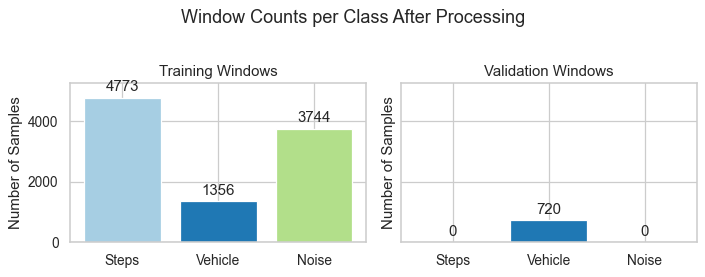

----------------------------------------

--- Skipping Sample Visualization (Stats Only Model) ---

--- Applying SMOTE to Training Statistical Features ---
Applying SMOTE with k_neighbors=5
 Shape after SMOTE - Stats: (14319, 21), Labels: (14319,)

Final Training Set Size: 14319 samples.


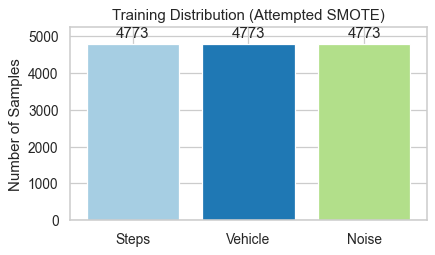


--- Scaling Statistical Features ---
Fitting Scaler...
Transforming Validation Features...
 Validation scaled.
Scaler saved: .\saved_models\stats_only_mlp_run_20250401_120851\scaler.pkl
----------------------------------------

--- Creating PyTorch Datasets and DataLoaders (Stats Only) ---
Train Dataset: 14319 samples.
Validation Dataset: 720 samples.
Train DataLoader created.
Validation DataLoader created.
----------------------------------------

--- Setting up Stats Only MLP Model, Optimizer, and Loss ---
Model Instantiated: StatsOnlyMLP
Using Class Weights: [1. 1. 1.]
Loss: CrossEntropyLoss (LS: 1.0e-05)
Optimizer: AdamW (LR: 1.0e-03, WD: 1.0e-05)
LR Scheduler: ReduceLROnPlateau (Factor: 0.2, Patience: 5)
----------------------------------------

--- Starting Model Training (Stats Only MLP) ---
Epoch 001 [1.7s] Tr L=0.1570 A=0.9582 | Val L=0.0041 A=1.0000 *Imprv | LR=1.0e-03

Saving checkpoint to .\saved_models\stats_only_mlp_run_20250401_120851\stats_only_mlp_run_20250401_120851_

In [26]:
# תא Code #1: ייבוא ספריות
# --- Core Libraries ---
import numpy as np
import pandas as pd
import os
import glob
import time
import random
from copy import deepcopy
import pickle
import warnings

# --- PyTorch Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# <<< אין צורך ב-torchvision.models אם לא משתמשים ב-CNN >>>
# from torchvision import transforms # לא נשתמש בטרנספורמציות תמונה
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Scikit-learn & Imblearn Libraries ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# --- Signal Processing & Feature Extraction ---
from scipy.signal import butter, filtfilt # אין צורך ב-spectrogram
import librosa

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
# import cv2 # <<< אין צורך ב-cv2 אם לא משנים גודל ספקטרוגרמות

# --- Configuration ---
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (6, 3)

# תא Code #2: הגדרות גלובליות ופרמטרים
# ======================== Device ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = 0 # Usually 0 for CPU or Windows/macOS data loading
print(f"Device: {device}, Workers: {num_workers}")

# ======================== Labels ========================
LABEL_STEPS    = 0; LABEL_VEHICLE  = 1; LABEL_NOISE    = 2
CLASS_NAMES    = ["Steps", "Vehicle", "Noise"]; NUM_CLASSES    = len(CLASS_NAMES)
print(f"Classes: {CLASS_NAMES}")

# ================= Signal Processing ==================
window_size    = 2000; fs = 1000.0; stride = 250
lowcut = 1.0; highcut = 100.0; order = 4

# ================= Feature Extraction =================
NUM_BASE_FEATURES = 8; NUM_MFCC_FEATURES = 13
NUM_STAT_FEATURES = NUM_BASE_FEATURES + NUM_MFCC_FEATURES # 21
# --- פרמטרים של ספקטרוגרמה הוסרו ---

# ===================== File Paths =====================
BASE_DIR = "."
DATA_DIR = os.path.join(BASE_DIR, "data")
INPUT_FILES_LABELS = {
    "man.csv": LABEL_STEPS, "car.csv": LABEL_VEHICLE, "car2.csv": LABEL_VEHICLE,
    #"car3.csv": LABEL_VEHICLE, "car4.csv": LABEL_VEHICLE, "noise.csv": LABEL_NOISE,
    "nothing.csv": LABEL_NOISE,
}

# ================== Train/Val Split ===================
VALIDATION_SPLIT_RATIO = 0.20
STRATIFY_SEED = 42

# ===================== Output Path ====================
RUN_NAME = f"stats_only_mlp_run_{time.strftime('%Y%m%d_%H%M%S')}" # שם חדש לריצה
SAVE_PATH_BASE = os.path.join(BASE_DIR, "saved_models", RUN_NAME)
os.makedirs(SAVE_PATH_BASE, exist_ok=True)
print(f"Output Path: {SAVE_PATH_BASE}")

# =================== Hyperparameters ==================
# <<< פרמטרים מופשטים יותר למודל MLP >>>
MLP_PARAMS = {
    "lr": 0.001, # קצב למידה אולי קצת יותר גבוה ל-MLP
    "weight_decay": 1e-5, # רגולריזציה קלה
    "dropout_p": 0.3, # דרופאאוט סביר
    "hidden_dim1": 128, # גודל שכבה נסתרת ראשונה
    "hidden_dim2": 64,  # גודל שכבה נסתרת שנייה
    "add_stat_noise": False, # אפשר להוסיף אם יש overfitting
    "stat_feature_noise_std": 0.1,
    "label_smoothing": 1e-5 # החלקה קלה
}
FINAL_EPOCHS = 100 # אולי צריך פחות אפוקים
FINAL_PATIENCE = 15 # סבלנות קצת פחות
FINAL_BATCH_SIZE = 64 # אפשר אולי להגדיל Batch Size כי המודל קל יותר
SCHEDULER_PATIENCE = max(1, FINAL_PATIENCE // 3); SCHEDULER_FACTOR = 0.2
print(f"MLP Params: LR={MLP_PARAMS['lr']:.1e}, Dropout={MLP_PARAMS['dropout_p']}")
print(f"Training: Batch={FINAL_BATCH_SIZE}, Epochs={FINAL_EPOCHS}, Patience={FINAL_PATIENCE}")

# תא Code #3: פונקציות עזר (גרסה מפושטת)
# תא Code #3: פונקציות עזר (גרסה סופית וקריאה)

# =====================================================================================
# =                           Data Preprocessing Functions                           =
# =====================================================================================

def create_windows_1d(signal_1d, label, window_size=window_size, stride=stride):
    """Creates overlapping windows from a 1D signal."""
    signal_1d = signal_1d.flatten() # Ensure 1D
    X_windows, y_labels = [], []
    if len(signal_1d) < window_size: return [], []
    for start in range(0, len(signal_1d) - window_size + 1, stride):
        window = signal_1d[start : start + window_size]
        X_windows.append(window)
        y_labels.append(label)
    return X_windows, y_labels

def apply_filter_1d(data_1d, lowcut=lowcut, highcut=highcut, fs=fs, order=order):
    """Applies a Butterworth bandpass filter to a 1D signal."""
    data_1d = data_1d.flatten()
    try:
        nyquist = 0.5 * fs
        low = max(lowcut/nyquist, 1e-6)
        high = min(highcut/nyquist, 1.0-1e-6)
        if low >= high:
            # print(f" Filter Error: Low cut >= High cut. Skipping.") # Debug
            return data_1d
        b, a = butter(order, [low, high], btype='band')
        if len(data_1d) <= order*3:
            # print(f" Warning: Not enough data for filter. Skipping.") # Debug
            return data_1d
        return filtfilt(b, a, data_1d, axis=0)
    except Exception as e:
        # print(f" Error applying filter: {e}") # Debug
        return data_1d

# =====================================================================================
# =                         Feature Extraction Functions                             =
# =====================================================================================
def extract_statistical_features(signal_1d, sr=fs, n_mfcc=NUM_MFCC_FEATURES):
    """Extracts various statistical and spectral features using librosa."""
    try:
        signal_float = signal_1d.astype(np.float32); features = []
        # Basic stats
        features.extend([np.mean(signal_float), np.std(signal_float), np.sqrt(np.mean(signal_float**2))])
        # Temporal
        features.append(np.mean(librosa.feature.zero_crossing_rate(y=signal_float)))
        # Spectral (needs STFT)
        stft_result = librosa.stft(signal_float, n_fft=N_FFT, hop_length=HOP_LENGTH); spec_mag = np.abs(stft_result)
        features.append(np.mean(librosa.feature.spectral_centroid(S=spec_mag, sr=sr)))
        features.append(np.mean(librosa.feature.spectral_bandwidth(S=spec_mag, sr=sr)))
        features.append(np.mean(librosa.feature.spectral_rolloff(S=spec_mag, sr=sr, roll_percent=0.85)))
        features.append(np.mean(librosa.feature.spectral_flatness(S=spec_mag)))
        # MFCCs
        mfccs_feats = librosa.feature.mfcc(y=signal_float, sr=sr, n_mfcc=n_mfcc); mfccs_mean = np.mean(mfccs_feats, axis=1)
        if mfccs_mean.shape[0] < n_mfcc: mfccs_mean = np.pad(mfccs_mean, (0, n_mfcc - mfccs_mean.shape[0]), mode='constant')
        elif mfccs_mean.shape[0] > n_mfcc: mfccs_mean = mfccs_mean[:n_mfcc]
        features.extend(mfccs_mean)
        # Final checks
        final_features = np.array(features, dtype=np.float32)
        if final_features.shape[0] != NUM_STAT_FEATURES: final_features = np.pad(final_features, (0, NUM_STAT_FEATURES - final_features.shape[0]), mode='constant')[:NUM_STAT_FEATURES]
        if np.isnan(final_features).any() or np.isinf(final_features).any(): final_features = np.nan_to_num(final_features, nan=0.0, posinf=0.0, neginf=0.0)
        return final_features
    except Exception as e:
        # print(f" Error extracting stats: {e}") # Debug
        return np.zeros(NUM_STAT_FEATURES, dtype=np.float32)

# =====================================================================================
# =                 PyTorch Dataset, Augmentation, and Model Classes               =
# =====================================================================================
class StatsOnlyDataset(Dataset):
    """Dataset for statistical features ONLY."""
    def __init__(self, stat_feats, labels, add_noise=False, noise_std=0.1):
        self.stat_feats = np.asarray(stat_feats, dtype=np.float32)
        self.labels = np.asarray(labels, dtype=np.int64)
        self.add_noise = add_noise; self.noise_std = noise_std
        assert len(self.stat_feats) == len(self.labels),"Data length mismatch"
        if len(self.stat_feats) > 0: assert self.stat_feats.shape[1] == NUM_STAT_FEATURES, "Stat features dim mismatch"
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        stat_feat_orig = self.stat_feats[idx]; label = self.labels[idx]
        if self.add_noise and self.noise_std > 0: noise = np.random.normal(0, self.noise_std, size=stat_feat_orig.shape); stat_feat = stat_feat_orig + noise.astype(stat_feat_orig.dtype)
        else: stat_feat = stat_feat_orig
        stat_tensor = torch.tensor(stat_feat, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return stat_tensor, label_tensor

class StatsOnlyMLP(nn.Module):
    """Simple MLP model for statistical features only."""
    def __init__(self, num_classes=NUM_CLASSES, dropout_p=0.3,
                 input_stat_features=NUM_STAT_FEATURES, hidden_dim1=128, hidden_dim2=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.LayerNorm(input_stat_features),
            nn.Linear(input_stat_features, hidden_dim1), nn.ReLU(), nn.Dropout(dropout_p),
            nn.Linear(hidden_dim1, hidden_dim2), nn.ReLU(), nn.Dropout(dropout_p),
            nn.Linear(hidden_dim2, num_classes)
        )
    def forward(self, stat_input):
        return self.mlp(stat_input)

# =====================================================================================
# =                   Training, Evaluation & Utility Functions                       =
# =====================================================================================
def train_epoch_stats_only(model, dataloader, criterion, optimizer, device):
    """Trains the stats-only model for one epoch."""
    model.train()
    running_loss=0.0; correct_predictions=0; total_samples=0;
    for batch_idx, (stat_feats, labels) in enumerate(dataloader):
        stat_feats, labels = stat_feats.to(device), labels.to(device)
        optimizer.zero_grad()
        try:
            outputs = model(stat_feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0); correct_predictions += (predicted == labels).sum().item();
        except Exception as e:
            print(f"Error training batch {batch_idx}: {e}")
            continue # Skip batch on error
    epoch_loss = running_loss/total_samples if total_samples>0 else 0
    epoch_acc = correct_predictions/total_samples if total_samples>0 else 0
    return epoch_loss,epoch_acc

@torch.no_grad()
def evaluate_model_stats_only(model, dataloader, criterion, device, is_final_eval=False):
    """Evaluates the stats-only model."""
    model.eval()
    running_loss=0.0; correct_predictions=0; total_samples=0; all_labels=[]; all_preds=[]
    for stat_feats, labels in dataloader:
        stat_feats, labels = stat_feats.to(device), labels.to(device)
        try:
            outputs = model(stat_feats)
            if not is_final_eval and criterion:
                loss=criterion(outputs,labels)
                running_loss+=loss.item()*labels.size(0);
            _,predicted=torch.max(outputs.data,1)
            total_samples+=labels.size(0); correct_predictions+=(predicted==labels).sum().item();
            all_labels.extend(labels.cpu().numpy()); all_preds.extend(predicted.cpu().numpy());
        except Exception as e:
            print(f"Error evaluating batch: {e}")
            continue # Skip batch on error
    epoch_loss = running_loss/total_samples if total_samples>0 and not is_final_eval else 0
    epoch_acc = correct_predictions/total_samples if total_samples>0 else 0
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds)

def save_final_model(epoch, model, optimizer, scaler, val_loss, val_acc, params, filename):
    """Saves the model checkpoint."""
    print(f"\nSaving checkpoint to {filename} (Epoch {epoch}, ValLoss {val_loss:.4f}, ValAcc {val_acc:.4f})")
    state = {
        'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
        'scaler_params': {'mean': scaler.mean_, 'scale': scaler.scale_, 'n_features': scaler.n_features_in_, 'n_samples': scaler.n_samples_seen_},
        'val_loss': val_loss, 'val_acc': val_acc, 'mlp_params': params,
        'fs': fs, 'window_size': window_size, 'stride': stride, 'num_stat_features': NUM_STAT_FEATURES,
    }
    try:
        torch.save(state, filename) # שמירה תקינה
    except Exception as e:
        print(f"Error saving checkpoint: {e}")

# <<< פונקציה מתוקנת >>>
def plot_training_history(history, save_dir, prefix=""):
    """Plots and saves the training/validation loss and accuracy curves."""
    history_path = os.path.join(save_dir, f"{prefix}train_history.png")
    print(f"\nSaving training history plot to {history_path}")
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10, 4)) # גודל סביר לגרף

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss', markersize=4)
    if 'val_loss' in history and any(x is not None for x in history['val_loss']):
         plt.plot(epochs, [l if l is not None else np.nan for l in history['val_loss']], 'ro--', label='Validation Loss', markersize=4)
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle=':')

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy', markersize=4)
    if 'val_acc' in history and any(x is not None for x in history['val_acc']):
        plt.plot(epochs, [a if a is not None else np.nan for a in history['val_acc']], 'ro--', label='Validation Accuracy', markersize=4)
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(bottom=0.0, top=1.05)
    plt.legend()
    plt.grid(True, linestyle=':')

    plt.tight_layout() # חשוב למנוע חפיפות

    # בלוק שמירה תקין
    try:
        plt.savefig(history_path)
        plt.close() # Close the plot to free memory
    except Exception as e:
        print(f"Error saving history plot: {e}")
        plt.close()

# <<< פונקציה מתוקנת >>>
def display_results(true_labels, pred_labels, dataset_name, save_dir=".", prefix="", class_names=CLASS_NAMES):
    """Calculates, prints, and plots evaluation metrics."""
    print(f"\n--- Results: {dataset_name} ---")
    # Input validation
    if not isinstance(true_labels, (list, np.ndarray)) or not isinstance(pred_labels, (list, np.ndarray)): print("Invalid input type."); return
    if len(true_labels) == 0 or len(pred_labels) == 0: print("Empty inputs."); return
    if len(true_labels) != len(pred_labels): print("Length mismatch."); return
    try:
        true_labels_int = np.asarray(true_labels).astype(int)
        pred_labels_int = np.asarray(pred_labels).astype(int)
    except ValueError: print("Cannot convert labels to integers."); return

    # חישוב והדפסת מדדים
    try:
        accuracy = accuracy_score(true_labels_int, pred_labels_int)
        print(f"Accuracy: {accuracy:.4f}")
        target_labels = list(range(len(class_names)))
        print("\nClassification Report:")
        print(classification_report(true_labels_int, pred_labels_int, target_names=class_names, labels=target_labels, zero_division=0))
        print("\nConfusion Matrix:")
        cm = confusion_matrix(true_labels_int, pred_labels_int, labels=target_labels)
        print(cm)
    except ValueError as ve: print(f"ERROR calculating metrics: {ve}"); return
    except Exception as e: print(f"Unexpected error calculating metrics: {e}"); return

    # יצירה ושמירה של גרף מטריצת הבלבול
    try:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)
        plt.title(f"{dataset_name}\nAcc: {accuracy:.4f}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.tight_layout()
        cm_path = os.path.join(save_dir, f"{prefix}{dataset_name}_CM.png")
        plt.savefig(cm_path)
        print(f"CM saved: {cm_path}")
        plt.close()
    except Exception as e:
        print(f"Error saving CM plot: {e}")
        plt.close() # נסה לסגור בכל מקרה
    finally:
        print("-" * 40)


# <<< פונקציה מתוקנת >>>
def plot_split_counts(labels, title, ax, class_names=CLASS_NAMES): # ברירת מחדל היא המשתנה הגלובלי
    """Helper function to plot class counts for train/val splits."""
    # ... (שאר הקוד של הפונקציה נשאר זהה) ...
    if len(labels)==0: ax.set_title(f"{title}\n(No Data)"); ax.set_xticks([]); ax.set_yticks([]); return
    counts = np.bincount(labels, minlength=len(class_names)) # השתמש באורך של class_names
    num_actual_classes = len(counts)
    # אם יש יותר ספירות מתוויות שמות, קח רק את אלה שקיימים
    counts_to_plot = counts[:len(class_names)]
    num_classes_to_plot = len(counts_to_plot)
    colors = plt.cm.Paired.colors[:num_classes_to_plot]
    class_names_to_show = class_names[:num_classes_to_plot]

    bars = ax.bar(class_names_to_show, counts_to_plot, color=colors) # השתמש ברשימות המסוננות
    ax.set_title(title)
    ax.set_ylabel("Number of Samples")
    ax.bar_label(bars, padding=3)
    ax.margins(y=0.1)
    ax.set_xticks(range(len(class_names_to_show)))
    ax.set_xticklabels(class_names_to_show)
# תא Code #4: טעינה והרחבה - ללא שינוי מהגרסה הקודמת שלך

# תא Code #4: טעינה (שמירת קבצים שלמים)

all_original_files_data = [] # List for tuples: (dataframe, label, filename)
signal_lengths_per_file = {} # Dictionary to store lengths per file

print("--- Loading Original Signals (Keeping Files Intact) ---")
for filename_rel, label in INPUT_FILES_LABELS.items():
    filepath = os.path.join(DATA_DIR, filename_rel)
    print(f"Loading: {filename_rel} (Label: {CLASS_NAMES[label]})")
    if not os.path.exists(filepath):
        print(f"  WARNING: File not found at {filepath}. Skipping.")
        continue
    try:
        # נטען את כל הקובץ וננסה לזהות כותרת
        header_row = None
        try:
            # ננסה לקרוא שורה ראשונה ולבדוק אם היא מספרית
            df_peek = pd.read_csv(filepath, header=None, nrows=1)
            pd.to_numeric(df_peek.iloc[0]) # נסיון המרה של השורה הראשונה
            header_row = None # הצליח - כנראה אין כותרת
        except (ValueError, TypeError, IndexError):
            header_row = 0 # נכשל - נניח שיש כותרת בשורה 0
            print(f"  Potential header detected. Will skip row 0 on actual load.")

        # טעינה סופית
        df = pd.read_csv(filepath, header=header_row) # טען עם או בלי כותרת

        # נמיר הכל למספרים וננקה שורות בעייתיות
        num_cols_before = df.shape[1]
        df = df.apply(pd.to_numeric, errors='coerce').dropna()
        num_cols_after = df.shape[1]
        if num_cols_before != num_cols_after:
             print(f"  Note: Some columns might have been dropped due to non-numeric data.")

        if not df.empty and df.shape[1] > 0: # ודא שיש נתונים ועמודות
            all_original_files_data.append((df, label, filename_rel)) # שמור את ה-DataFrame
            signal_lengths_per_file[filename_rel] = len(df)
            print(f"  Loaded {len(df)} valid rows with {df.shape[1]} columns.")
        else:
            print(f"  WARNING: No valid data after cleaning or no columns left. Skipping file.")

    except pd.errors.EmptyDataError:
        print(f"  WARNING: File {filename_rel} is empty. Skipping.")
    except Exception as e:
        print(f"  ERROR loading or processing {filename_rel}: {e}")

print("-" * 40)
print(f"Total original files loaded successfully: {len(all_original_files_data)}")
if not all_original_files_data:
    raise ValueError("CRITICAL: No original files were loaded successfully.")

# --- הדמיית אורך הקבצים המקוריים ---
file_lengths = list(signal_lengths_per_file.values())
plt.figure(figsize=(6, 3))
if file_lengths:
    plt.hist(file_lengths, bins=10, color='purple', edgecolor='black') # פחות בינים לקבצים
else:
    plt.text(0.5, 0.5, 'No data loaded', ha='center', va='center')
plt.title("Distribution of Raw File Lengths (Samples per File)")
plt.xlabel("Number of Samples")
plt.ylabel("Frequency (Number of Files)")
plt.grid(True, axis='y', linestyle=':')
plt.tight_layout()
plt.show()

# תא Code #5: פיצול Train/Validation - ללא שינוי מהגרסה הקודמת שלך

# תא Code #5: פיצול Train/Validation (ברמת הקובץ)

# הכן רשימות לפיצול
original_data = [item[0] for item in all_original_files_data] # DataFrames
original_labels = [item[1] for item in all_original_files_data] # Labels
original_filenames = [item[2] for item in all_original_files_data] # Filenames

print(f"\n--- Splitting {len(original_data)} Original Files ({VALIDATION_SPLIT_RATIO*100:.0f}% Validation) ---")
print(f"Using stratification seed: {STRATIFY_SEED}")

# בדוק אם אפשר לעשות סטרטיפיקציה (לפחות 2 דגימות בקלאס הכי קטן)
min_class_count_files = np.min(np.bincount(original_labels)) if len(original_labels) > 0 else 0
can_stratify_files = min_class_count_files >= 2

if not can_stratify_files and len(original_labels) > 0:
     print(f"WARNING: Cannot stratify based on files! Least populated class has {min_class_count_files} files. Splitting without stratification.")

# בצע פיצול על האינדקסים של הקבצים
file_indices = list(range(len(original_labels)))
train_file_indices, val_file_indices = train_test_split(
    file_indices,
    test_size=VALIDATION_SPLIT_RATIO,
    random_state=STRATIFY_SEED,
    stratify=original_labels if can_stratify_files else None, # בצע סטרטיפיקציה אם אפשר
    shuffle=True
)

# צור רשימות נפרדות לקבצי אימון וולידציה
# כל רשימה מכילה טאפלים של (dataframe, label, filename)
train_files_to_process = [all_original_files_data[i] for i in train_file_indices]
val_files_to_process = [all_original_files_data[i] for i in val_file_indices]

print(f"Split complete:")
print(f"  Training files: {len(train_files_to_process)}")
print(f"  Validation files: {len(val_files_to_process)}")

# --- הדמיית ספירת הקבצים המקוריים אחרי הפיצול ---
train_file_labels = [item[1] for item in train_files_to_process]
val_file_labels = [item[1] for item in val_files_to_process]

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
fig.suptitle("Original File Counts per Class After Split", y=1.02)

# השתמש בפונקציה plot_split_counts שהגדרנו קודם (היא צריכה להיות בתא #3)
plot_split_counts(train_file_labels, "Training Set Files", axes[0])
plot_split_counts(val_file_labels, "Validation Set Files", axes[1])
plt.tight_layout(); plt.show()
# תא Code #6: עיבוד נתונים - חלונות ופיצ'רים (גרסה סטטיסטית בלבד)
# תא Code #6: הרחבה לערוצים ועיבוד (פיצ'רים סטטיסטיים בלבד)

def expand_channels_and_process_stats_only(files_to_process_list, dataset_name):
    """Expands files into channels, filters, windows, and extracts STATS."""
    all_stat_features, all_window_labels = [], []
    total_windows_processed, skipped_windows = 0, 0
    fail_reason_counts = {'filter_short': 0, 'stat_nan_inf': 0, 'stat_shape': 0, 'other_exception': 0, 'channel_empty': 0}
    num_channels_processed = 0

    print(f"\n--- Expanding Channels & Processing for {dataset_name} Set (Stats Only) ---")
    if not files_to_process_list: print("No files to process."); return [], []

    num_files = len(files_to_process_list)
    for file_idx, (df_signal, label, filename_rel) in enumerate(files_to_process_list):
        print(f" Proc file {file_idx+1}/{num_files} ({filename_rel})...", end='\r')
        num_cols = df_signal.shape[1]

        for col_idx in range(num_cols):
            # שלב 1: קבל ערוץ בודד (כבר נקי מטעינה)
            signal_1d_orig = df_signal.iloc[:, col_idx].values
            channel_id = f"{filename_rel}_ch{col_idx}"
            num_channels_processed += 1

            if len(signal_1d_orig) == 0: # בדיקה נוספת
                 fail_reason_counts['channel_empty'] += 1; skipped_windows += 1; continue

            # שלב 2: סינון הערוץ
            filtered_signal_1d = apply_filter_1d(signal_1d_orig)
            if len(filtered_signal_1d) < window_size:
                 fail_reason_counts['filter_short'] += 1; skipped_windows += (len(filtered_signal_1d) // stride) if stride > 0 else 1; continue

            # שלב 3: יצירת חלונות מהערוץ
            windows_1d, window_labels = create_windows_1d(filtered_signal_1d, label)
            if not windows_1d: continue

            # שלב 4: חילוץ פיצ'רים סטטיסטיים מכל חלון
            for i, w_1d in enumerate(windows_1d):
                try:
                    stat_feats = extract_statistical_features(w_1d, sr=fs, n_mfcc=NUM_MFCC_FEATURES)
                    is_nan_inf = np.isnan(stat_feats).any() or np.isinf(stat_feats).any()
                    is_wrong_shape = stat_feats.shape[0] != NUM_STAT_FEATURES
                    if is_nan_inf: skipped_windows += 1; fail_reason_counts['stat_nan_inf'] += 1; continue
                    if is_wrong_shape: skipped_windows += 1; fail_reason_counts['stat_shape'] += 1; continue
                    all_stat_features.append(stat_feats); all_window_labels.append(window_labels[i]); total_windows_processed += 1
                except Exception as e: skipped_windows += 1; fail_reason_counts['other_exception'] += 1; continue

    print(f"\nFinished expanding & processing {dataset_name}:")
    print(f"  Total channels processed: {num_channels_processed}")
    print(f"  Total windows generated: {total_windows_processed}")
    print(f"  Total windows skipped: {skipped_windows}")
    print(f"  Skipped reasons: {fail_reason_counts}")
    return (np.array(all_stat_features, dtype=np.float32),
            np.array(all_window_labels, dtype=np.int64))

# --- הרצת התהליך על קבצי האימון והוולידציה ---
X_stat_train_raw, y_train_raw = expand_channels_and_process_stats_only(train_files_to_process, "Training")
X_stat_val, y_val = expand_channels_and_process_stats_only(val_files_to_process, "Validation")

print("-" * 40)
# --- הדמיית התפלגות החלונות ---
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True); fig.suptitle("Window Counts per Class After Processing", y=1.02)
if len(y_train_raw) > 0: print(f"Processed Training:\n Stats: {X_stat_train_raw.shape}\n Labels: {y_train_raw.shape}"); plot_split_counts(y_train_raw, "Training Windows", axes[0])
else: print("No training windows.")
if len(y_val) > 0: print(f"\nProcessed Validation:\n Stats: {X_stat_val.shape}\n Labels: {y_val.shape}"); plot_split_counts(y_val, "Validation Windows", axes[1])
else: print("No validation windows.")
plt.tight_layout(); plt.show(); print("-" * 40)
if len(y_train_raw) == 0: raise ValueError("CRITICAL: No training windows generated.")
# תא Code #7: ויזואליזציה - לא רלוונטי כי אין ספקטרוגרמות
print("\n--- Skipping Sample Visualization (Stats Only Model) ---")

# תא Code #8: SMOTE ו-Scaling (רק על סטטיסטיקות)
print("\n--- Applying SMOTE to Training Statistical Features ---")
X_stat_train_smote = X_stat_train_raw.copy(); y_train_smote = y_train_raw.copy()
min_samples = np.min(np.bincount(y_train_smote)) if len(y_train_smote)>0 else 0
num_classes_present = len(np.unique(y_train_smote))
if min_samples > 1 and num_classes_present > 1:
    k = min(5, max(1, min_samples - 1)); print(f"Applying SMOTE with k_neighbors={k}")
    smote = SMOTE(random_state=STRATIFY_SEED, k_neighbors=k)
    try:
        X_stat_train_smote, y_train_smote = smote.fit_resample(X_stat_train_raw, y_train_raw)
        print(f" Shape after SMOTE - Stats: {X_stat_train_smote.shape}, Labels: {y_train_smote.shape}")
    except ValueError as e: print(f"SMOTE Error: {e}. Using original."); X_stat_train_smote=X_stat_train_raw; y_train_smote=y_train_raw
else: reason = "minority class too small" if min_samples<=1 else "only one class"; print(f"Skipping SMOTE: {reason}."); X_stat_train_smote=X_stat_train_raw; y_train_smote=y_train_raw
print(f"\nFinal Training Set Size: {len(y_train_smote)} samples.")
plt.figure(figsize=(5, 3)); ax=plt.gca(); plot_split_counts(y_train_smote, "Training Distribution (Attempted SMOTE)", ax); plt.tight_layout(); plt.show()
print("\n--- Scaling Statistical Features ---")
scaler = StandardScaler(); print("Fitting Scaler..."); X_stat_train_scaled = scaler.fit_transform(X_stat_train_smote)
print("Transforming Validation Features...")
if len(X_stat_val)>0: X_stat_val_scaled = scaler.transform(X_stat_val); print(" Validation scaled.")
else: X_stat_val_scaled = np.array([]); print(" No validation data.")
scaler_filepath = os.path.join(SAVE_PATH_BASE, "scaler.pkl");
try: pickle.dump(scaler, open(scaler_filepath, 'wb')); print(f"Scaler saved: {scaler_filepath}")
except Exception as e: print(f"Error saving scaler: {e}")
print("-" * 40)

# תא Code #9: Dataset ו-DataLoader (מותאם לסטטיסטיקות בלבד)
print("\n--- Creating PyTorch Datasets and DataLoaders (Stats Only) ---")
try:
    if len(y_train_smote)==0: raise ValueError("No training data.")
    train_dataset = StatsOnlyDataset(stat_feats=X_stat_train_scaled, labels=y_train_smote, add_noise=MLP_PARAMS["add_stat_noise"], noise_std=MLP_PARAMS["stat_feature_noise_std"])
    print(f"Train Dataset: {len(train_dataset)} samples.")
    if len(y_val)>0: val_dataset = StatsOnlyDataset(stat_feats=X_stat_val_scaled, labels=y_val, add_noise=False); print(f"Validation Dataset: {len(val_dataset)} samples.")
    else: val_dataset = None; print("No validation dataset.")
except Exception as e: raise ValueError(f"Failed dataset creation: {e}") from e
train_loader = DataLoader(train_dataset, batch_size=FINAL_BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True if device.type=='cuda' else False, drop_last=(len(train_dataset)>FINAL_BATCH_SIZE))
print(f"Train DataLoader created.")
if val_dataset: val_loader = DataLoader(val_dataset, batch_size=FINAL_BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True if device.type=='cuda' else False, drop_last=False); print(f"Validation DataLoader created.")
else: val_loader = None; print("Validation DataLoader not created.")
print("-" * 40)

# תא Code #10: הגדרת מודל MLP, אופטימייזר, Loss
print("\n--- Setting up Stats Only MLP Model, Optimizer, and Loss ---")
model = StatsOnlyMLP(num_classes=NUM_CLASSES, dropout_p=MLP_PARAMS["dropout_p"], input_stat_features=NUM_STAT_FEATURES, hidden_dim1=MLP_PARAMS["hidden_dim1"], hidden_dim2=MLP_PARAMS["hidden_dim2"]).to(device)
print(f"Model Instantiated: {model.__class__.__name__}")
if len(y_train_smote)>0: class_counts=np.maximum(np.bincount(y_train_smote, minlength=NUM_CLASSES),1); total_samples=class_counts.sum(); class_weights=total_samples/(NUM_CLASSES*class_counts); class_weights_tensor=torch.tensor(class_weights,dtype=torch.float).to(device); print(f"Using Class Weights: {class_weights_tensor.cpu().numpy()}")
else: class_weights_tensor=None; print("Class weights disabled.")
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=MLP_PARAMS["label_smoothing"])
print(f"Loss: CrossEntropyLoss (LS: {MLP_PARAMS['label_smoothing']:.1e})")
optimizer = optim.AdamW(model.parameters(), lr=MLP_PARAMS["lr"], weight_decay=MLP_PARAMS["weight_decay"])
print(f"Optimizer: AdamW (LR: {MLP_PARAMS['lr']:.1e}, WD: {MLP_PARAMS['weight_decay']:.1e})")
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=False)
print(f"LR Scheduler: ReduceLROnPlateau (Factor: {SCHEDULER_FACTOR}, Patience: {SCHEDULER_PATIENCE})")
print("-" * 40)

# תא Code #11: לולאת האימון (שימוש בפונקציות הסטטיסטיות)
print("\n--- Starting Model Training (Stats Only MLP) ---")
best_val_loss = float('inf'); best_epoch = -1; epochs_no_improve = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
final_model_save_path = os.path.join(SAVE_PATH_BASE, f"{RUN_NAME}_best_model.pth")
start_time_training = time.time()
for epoch in range(1, FINAL_EPOCHS + 1):
    epoch_start_time = time.time()
    # <<< קריאה לפונקציית אימון סטטיסטית >>>
    train_loss, train_acc = train_epoch_stats_only(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
    val_loss, val_acc = None, None
    if val_loader:
        # <<< קריאה לפונקציית הערכה סטטיסטית >>>
        val_loss, val_acc, _, _ = evaluate_model_stats_only(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
    else: history['val_loss'].append(None); history['val_acc'].append(None)
    epoch_duration = time.time() - epoch_start_time
    log_msg = f"Epoch {epoch:03d} [{epoch_duration:.1f}s] Tr L={train_loss:.4f} A={train_acc:.4f}"
    save_model_flag = False
    if val_loader and val_loss is not None:
        log_msg += f" | Val L={val_loss:.4f} A={val_acc:.4f}"
        scheduler.step(val_loss)
        if val_loss < best_val_loss: log_msg += f" *Imprv"; best_val_loss=val_loss; best_epoch=epoch; epochs_no_improve=0; save_model_flag=True
        else: epochs_no_improve += 1; log_msg += f" ({epochs_no_improve}/{FINAL_PATIENCE})"
    print(log_msg + f" | LR={optimizer.param_groups[0]['lr']:.1e}")
    if save_model_flag: save_final_model(epoch, model, optimizer, scaler, val_loss, val_acc, MLP_PARAMS, final_model_save_path) # שמירת פרמטרי MLP
    if val_loader and epochs_no_improve >= FINAL_PATIENCE: print(f"\nEarly stopping @ Epoch {epoch}."); break
    if not val_loader and epoch >= FINAL_EPOCHS: print(f"\nMax epochs reached.")
total_training_time = time.time() - start_time_training
print(f"\n--- Training Finished ({total_training_time / 60:.2f} min) ---")
if best_epoch != -1: print(f"Best Val Loss: {best_val_loss:.4f} @ Epoch {best_epoch}. Model saved: {final_model_save_path}")
else: print("No best model saved (or no validation).")
print("-" * 40)

# תא Code #12: גרף היסטוריית האימון - ללא שינוי

plot_training_history(history, SAVE_PATH_BASE, prefix="final_stats_mlp_")

# תא Code #13: הערכה סופית (טעינת מודל MLP)
print("\n--- Final Stats Only MLP Evaluation on Held-Out Validation Set ---")
model_loaded = False; model_path_to_load = final_model_save_path
if best_epoch != -1 and os.path.exists(model_path_to_load):
    print(f"Loading best stats-only model: {model_path_to_load}")
    try:
        checkpoint = torch.load(model_path_to_load, map_location=device, weights_only=False)
        eval_scaler = StandardScaler(); eval_scaler.mean_ = checkpoint['scaler_params']['mean']; eval_scaler.scale_ = checkpoint['scaler_params']['scale']
        eval_scaler.n_features_in_ = checkpoint['scaler_params']['n_features']; eval_scaler.n_samples_seen_ = checkpoint['scaler_params']['n_samples']
        assert eval_scaler.n_features_in_ == NUM_STAT_FEATURES, "Scaler mismatch"
        print("Scaler loaded.")
        # <<< טעינת המודל הנכון >>>
        eval_params = checkpoint.get('mlp_params', MLP_PARAMS) # קבל פרמטרי MLP מה-ckpt
        eval_model = StatsOnlyMLP(
            num_classes=NUM_CLASSES,
            dropout_p=eval_params.get('dropout_p', MLP_PARAMS["dropout_p"]),
            input_stat_features=eval_scaler.n_features_in_,
            hidden_dim1=eval_params.get('hidden_dim1', MLP_PARAMS["hidden_dim1"]),
            hidden_dim2=eval_params.get('hidden_dim2', MLP_PARAMS["hidden_dim2"])
        ).to(device)
        eval_model.load_state_dict(checkpoint['model_state_dict'])
        eval_model.eval(); model_loaded = True; print("StatsOnlyMLP state loaded.")
    except Exception as e: print(f"ERROR loading checkpoint: {e}")
else: print(f"Skipping evaluation: Best model checkpoint not found at {model_path_to_load} or was not saved.")
if model_loaded and val_loader:
    print(f"\nEvaluating on Validation Set ({len(val_dataset)} samples)...")
    # <<< קריאה לפונקציית הערכה סטטיסטית >>>
    _, _, true_labels_np, pred_labels_np = evaluate_model_stats_only(eval_model, val_loader, None, device, is_final_eval=True)
    display_results(true_labels_np, pred_labels_np, "ValidationSet", SAVE_PATH_BASE, prefix="final_stats_mlp_eval_")
elif model_loaded and not val_loader: print("\nNo validation data/loader.")
else: print("\nSkipping validation set evaluation.")
print("\n=== Full Stats-Only MLP Notebook Finished ===")